In [2]:
import numpy as np 
import math as math
from matplotlib import pyplot as plt 
from IPython.display import display, Math
%config InlineBackend.figure_format ='retina' # Pour avoir de jolis plots sur ecran retina
#%matplotlib notebook
from scipy.integrate import odeint

In [3]:
### Data ###

dp     = 0.008                                                     # Particule diameter [m]
dt     = 0.05                                                      # Tube diameter [m]
eta    = 0.5                                                       # Effectiveness factor
T      = 653.15                                                    # Temperature [K]
P      = 20*10**5                                                  # Pressure [Pa]
R      = 8.314462                                                  # Boltzman constant
k      = 2.8*10**8*math.exp(-96000/(R*T))                          # Rate constant
K      = 10**(-1.764+1910/T)                                       # Equilibrium constant
epsi   = 0.38 + 0.073*(1+(dt/dp - 2)**2/(dt/dp)**2)                # Void fraction
rho_b  = 2550*(1-epsi)                                             # Bed density

K_CO   = 0.6                                                       # Adsorption constante CO
K_CO2  = 4.1                                                       # Adsorption constante CO2
K_H2   = 4.1                                                       # Adsorption constante H2
K_H2O  = 1.3                                                       # Adsorption constante H2O


L      = 0.3                                                       # Tube length [m]
Ftot   = 238                                                       # Total molar flow [mol/h]
Vdot   = Ftot*R*T/P                                                # Gas flow [m³/h]
us     = (Vdot / (math.pi*(dt/2)**2))/3600                         # Superficial velocity [m/s]
C_co   = 35/Vdot

xsi    = np.linspace(0, 1, 10000)                                  # Adimensionnal dimension
Beta   = L*rho_b/us
Pe_dp  = [0.2, 0.5, 1, 2]

# QUESTION 1

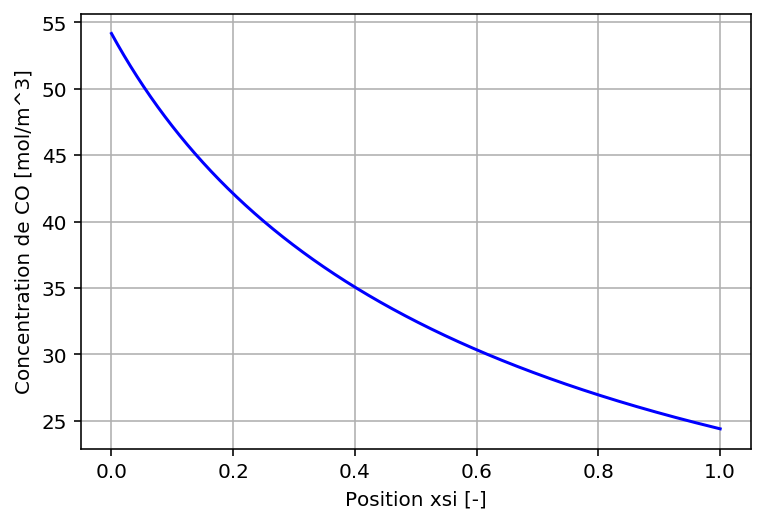

24.390682197338585


In [40]:
### Question 1 ### 

eta    = 0.5                      # Effectiveness factor 
Xstart = 0
Xend   = 1
Ustart = 35/Vdot                  # Condition initiale CO [mol/m^3] 


def Reactor_without_dispersion(X):
    h = (Xend-Xstart)/len(X)
    U = np.zeros(len(X))
    U[0] = Ustart
    i = 1
    for i in range(len(X)-1):
        num = k*K_CO*K_H2O*(U[i]*(U[i]+38.6875)-((72.73-U[i])*(182.6047-U[i]))/K)
        den = (1 + K_CO*U[i] + K_H2O*(U[i] +38.6875) + K_CO2*(72.73-U[i]) + K_H2*(182.6047-U[i]))**2
        U[i+1] =  U[i] + h*(-Beta*eta)*num/den
    plt.figure()
    plt.plot(X,U,'b')
    plt.xlabel("Position xsi [-]")
    plt.ylabel("Concentration de CO [mol/m^3]")
    plt.grid()
    plt.show()
    return U

CO = Reactor_without_dispersion(xsi)
print(CO[-1])
### PLOT POUR LE PROFIL DE CONCENTRATION DE CO ###

## Concentration profile plot for H2O

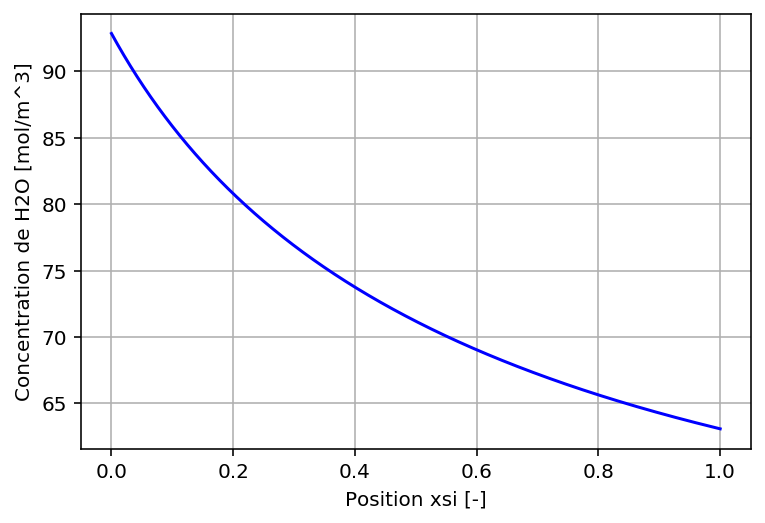

In [41]:
### PLOT POUR LE PROFIL DE CONCENTRATION DE H2O ###

H2O = np.linspace(0, 1, 10000)
j = 1
for j in range(len(xsi)):
    H2O[j] = CO[j] + 38.6875
    

plt.figure()
plt.plot(xsi,H2O,'b')
plt.xlabel("Position xsi [-]")
plt.ylabel("Concentration de H2O [mol/m^3]")
plt.grid()
plt.show()

## Concentration profile plot for CO2

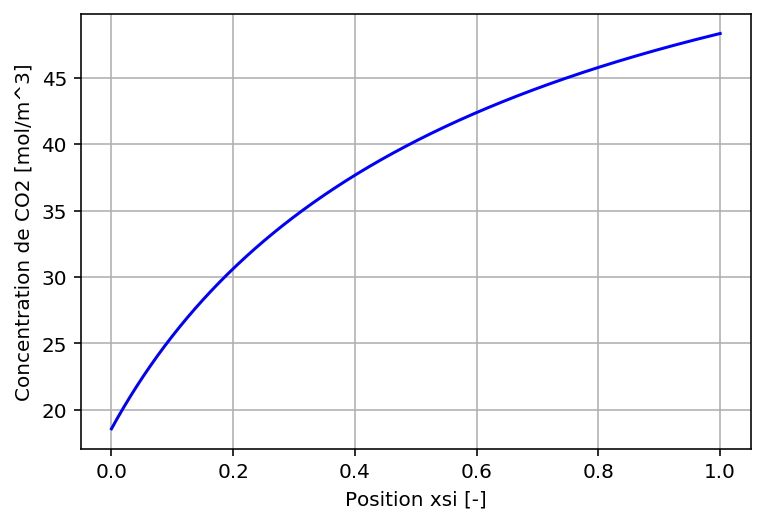

In [42]:
### PLOT POUR LE PROFIL DE CONCENTRATION DE CO2 ###

CO2 = np.linspace(0, 1, 10000)
i = 1
for i in range(len(xsi)):
    CO2[i] = 72.73 - CO[i]

plt.figure()
plt.plot(xsi,CO2,'b')
plt.xlabel("Position xsi [-]")
plt.ylabel("Concentration de CO2 [mol/m^3]")
plt.grid()
plt.show()

## Concentration profile plot for H2

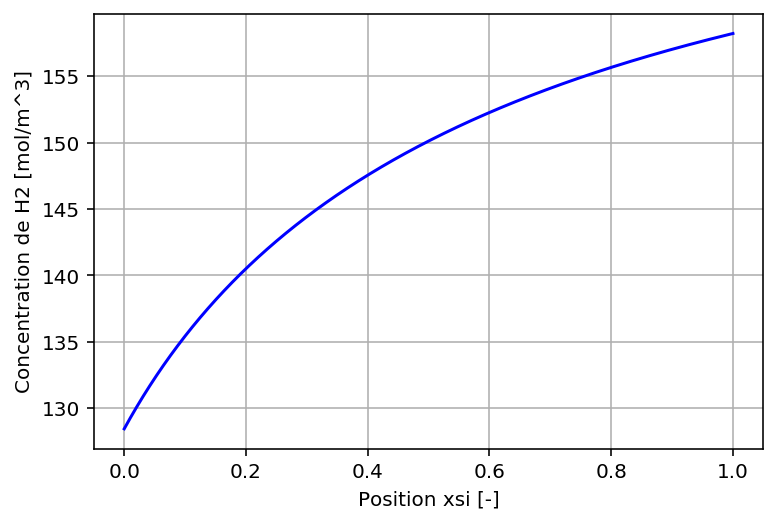

In [43]:
### PLOT POUR LE PROFIL DE CONCENTRATION DE H2 ###

H2 = np.linspace(0, 1, 10000)
i = 1
for i in range(len(xsi)):
    H2[i] = 182.6047 - CO[i]

plt.figure()
plt.plot(xsi,H2,'b')
plt.xlabel("Position xsi [-]")
plt.ylabel("Concentration de H2 [mol/m^3]")
plt.grid()
plt.show()

# QUESTION 2

### Calcul des diffusivités et des nonbres de Peclet (L)


In [44]:
### Diffusivités ###
DeA = np.zeros(len(Pe_dp))
for i in range(len(Pe_dp)):
    DeA[i] = (us*dp/epsi)*(1/Pe_dp[i])
print(DeA)

### Pe ###
Pe_L = np.zeros(4)
for j in range(4):
    Pe_L[j] = (us*L/epsi)*(1/DeA[j])
print(Pe_L)


[0.00751296 0.00300518 0.00150259 0.0007513 ]
[ 7.5  18.75 37.5  75.  ]


### Résolution de l'équation 

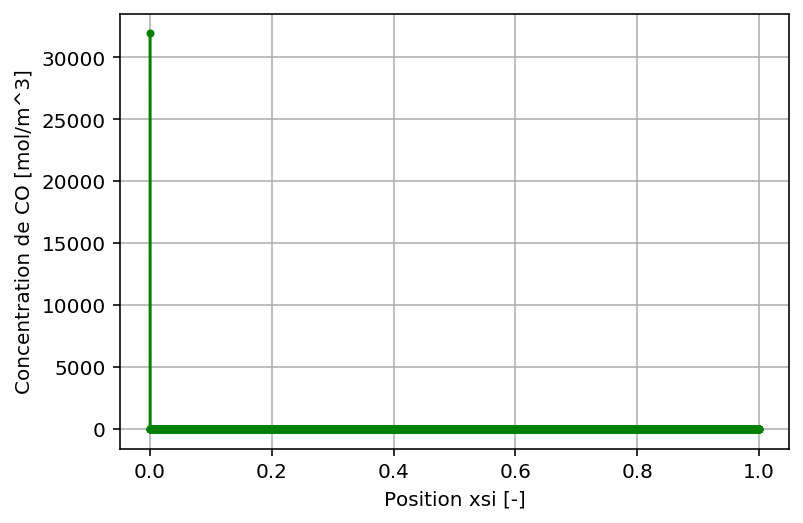

In [66]:
Pe = 7.5                                      # On fixe le Peclet (defini par rapport a la longueur du reacteur)

def Reactor_with_dispersion(X, C_CO):
    #print(Pe)
    h = (Xend-Xstart)/len(X)
    C_new = np.zeros(len(X))
    crit = 100000             # Critère de convergence pour la convergence des sommes des valeurs des tableaux 
    #Marche avec 1 million mais bug total avec 100000 -> ne raffine pas du tout la solution 
    while (abs(np.sum(C_CO)-np.sum(C_new)) > crit):  #On fixe le critère de convergence en comparant les sommes de tous les elements du tableau 
        C_new = np.zeros(len(X))
        for i in range(len(X)-1):
            num = k*K_CO*K_H2O*(C_CO[i]*(C_CO[i]+38.6875)-((72.73-C_CO[i])*(182.6047-C_CO[i]))/K)
            den = (1 + K_CO*C_CO[i] + K_H2O*(C_CO[i] +38.6875) + K_CO2*(72.73-C_CO[i]) + K_H2*(182.6047-C_CO[i]))**2
            C_new[i] = ((-Pe*(h**2))/2)*((Beta*eta)*(((num/den)) + ((C_CO[i+1]-C_CO[i-1])/(2*h)) - (C_CO[i+1]-C_CO[i-1])/(Pe*(h**2))))
            #print(C_new)
        C_CO = C_new
    return C_CO
#C_final = np.zeros(len(xsi)-1)
C_final = Reactor_with_dispersion(xsi, CO)

# Problème de local variable not assigned, peut etre mettre en argument avec un autre nom reglerait le probleme, a tester 
plt.figure()
plt.plot(xsi , C_final, '.-g')
plt.xlabel("Position xsi [-]")
plt.ylabel("Concentration de CO [mol/m^3]")
plt.grid()
plt.show()
